# Clustering et visualisations

In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1 - Chargement et préparation des données

In [2]:
#Importation du fichier 
dispo_alimentaire_population_final = pd.read_csv(r"C:\Users\DAVID Virginie\Documents\Cours_Data\Projet 9\dispo_alimentaire_population_final.csv")

In [3]:
#Affichage du df
dispo_alimentaire_population_final.head()

,Code Domaine_x,Domaine_x,Code zone,Zone_x,Code Élément_x,Élément_x,Code Produit_x,Produit_x,Année_x,Unité_x,...,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,OA,Séries temporelles annuelles,79,Allemagne,511.0,Population totale,3010.0,Population-Estimations,2000.0,1000 personnes,...,6110.0,Valeur US $,22008.0,Produit Intérieur Brut,2017.0,2017.0,Millions d’USD,3.690849e+06,X,Ciffre de sources internationales
1,OA,Séries temporelles annuelles,79,Allemagne,511.0,Population totale,3010.0,Population-Estimations,2000.0,1000 personnes,...,6110.0,Valeur US $,22008.0,Produit Intérieur Brut,2017.0,2017.0,Millions d’USD,3.690849e+06,X,Ciffre de sources internationales
2,OA,Séries temporelles annuelles,79,Allemagne,511.0,Population totale,3010.0,Population-Estimations,2000.0,1000 personnes,...,6110.0,Valeur US $,22008.0,Produit Intérieur Brut,2017.0,2017.0,Millions d’USD,3.690849e+06,X,Ciffre de sources internationales
3,OA,Séries temporelles annuelles,79,Allemagne,511.0,Population totale,3010.0,Population-Estimations,2000.0,1000 personnes,...,6110.0,Valeur US $,22008.0,Produit Intérieur Brut,2017.0,2017.0,Millions d’USD,3.690849e+06,X,Ciffre de sources internationales
4,OA,Séries temporelles annuelles,79,Allemagne,511.0,Population totale,3010.0,Population-Estimations,2000.0,1000 personnes,...,6110.0,Valeur US $,22008.0,Produit Intérieur Brut,2017.0,2017.0,Millions d’USD,3.690849e+06,X,Ciffre de sources internationales


In [4]:
#Prendre un échantillon du df et figer pour avoir les mêmes résultats à chaque fois qu'on fasse tourner le code
dispo_alimentaire_population_final = dispo_alimentaire_population_final.sample(n=10000, random_state=42)

# 2  - Sélection et standardisation des variables numériques

In [5]:
#Sélectionner les colonnes numériques pour le clustering
X = dispo_alimentaire_population_final.select_dtypes(include=[np.number])

In [6]:
# Suppression des colonnes avec toutes les valeurs NaN ou constantes
X = X.dropna(axis=1, how='all')
X = X.loc[:, X.nunique() > 1]

In [7]:
# Imputation des valeurs manquantes par la moyenne des colonnes
X = X.fillna(X.mean())

In [8]:
#Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3 - Analyse de la variance pour filtrage

In [9]:
#Vérification variance des colonnes 
print(np.var(X_scaled, axis=0))

[1. 1. 1. 1. 1. 1. 1.]


In [10]:
#Supprimer les variables quasi-constantee
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_scaled)

# 4 - ACP

In [11]:
#ACP avec sklearn (sans restriction du nombre de composantes)
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
explained_var = pca.explained_variance_ratio_
print("Variance expliquée :", explained_var)

Variance expliquée : [0.23940824 0.1963982  0.15593715 0.14244881 0.13707709 0.12795356
 0.00077696]


### Diagramme de Pareto (variance expliquée)

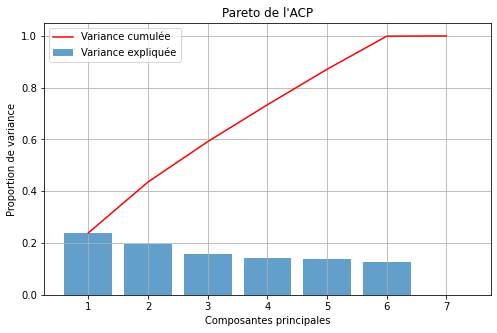

In [12]:
plt.figure(figsize=(8, 5))
x = range(1, len(explained_var)+1)
plt.bar(x, explained_var, alpha=0.7, label='Variance expliquée')
plt.plot(x, np.cumsum(explained_var), '-r', label='Variance cumulée')
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance")
plt.title("Pareto de l'ACP")
plt.legend()
plt.grid()
plt.show()

### Visualisation du cercle de corrélation (ACP)

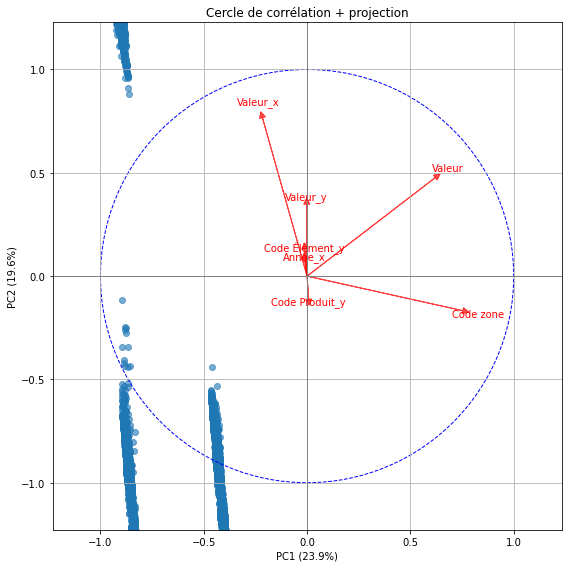

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def biplot(score, coeff, labels=None, categories=None, var_ratio=None, figsize=(8, 8)):
    xs = score[:, 0]
    ys = score[:, 1]

    plt.figure(figsize=figsize)
    if categories is not None:
        sc = plt.scatter(xs, ys, c=categories, cmap='viridis', alpha=0.6)
        plt.colorbar(sc, label="Catégorie")
    else:
        plt.scatter(xs, ys, alpha=0.6)

#Affichage des vecteurs des variables
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1],
                  color='r', alpha=0.7, head_width=0.03, head_length=0.03)
        if labels is not None:
            plt.text(coeff[i, 0]*1.1, coeff[i, 1]*1.1, labels[i],
                     color='r', ha='center', va='center')

#Cercle de corrélation
    circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.xlabel(f"PC1 ({var_ratio[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({var_ratio[1]*100:.1f}%)")
    plt.title("Cercle de corrélation + projection")
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
# Pour le cercle de corrélation, on prend seulement les 2 premières composantes
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)
coeff = pca2.components_.T
var_ratio = pca2.explained_variance_ratio_
labels = X.columns.tolist()

biplot(score=X_pca2, coeff=coeff, labels=labels, var_ratio=var_ratio)

# 5 - Dendrogramme pour analyse hiérarchique

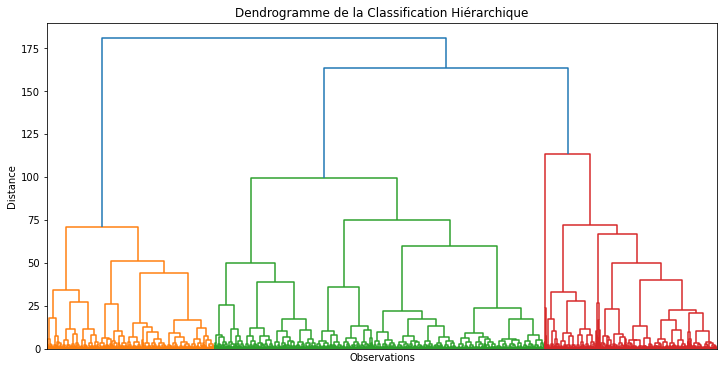

In [14]:
#Construire le graphique
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)
plt.title("Dendrogramme de la Classification Hiérarchique")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

# 3  - Méthode du coude pour choisir k (KMeans)

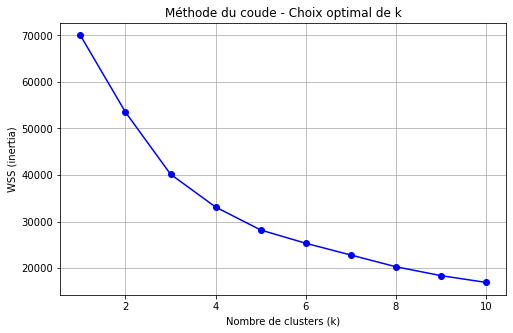

In [15]:
#Choix nombre clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Définir la plage de k à tester
K = range(1, 11)
wss = []

# 2. Calculer WSS pour chaque k
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_filtered)
    wss.append(kmeans.inertia_)

# 3. Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(K, wss, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WSS (inertia)')
plt.title("Méthode du coude - Choix optimal de k")
plt.grid(True)
plt.show()


# 4 - K-Means via  ACP

In [16]:
#K-Means avec 4 clusters 
from sklearn.cluster import KMeans

# Appliquer K-Means avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_filtered)

import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4930, 1: 2523, 2: 2518, 3: 29}


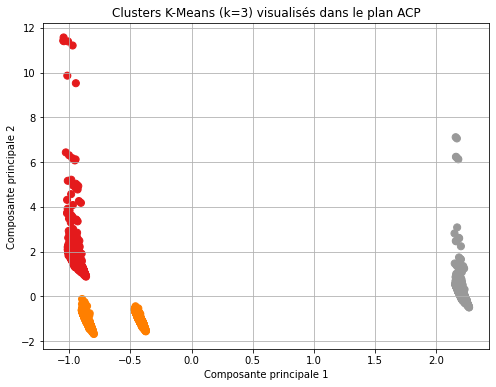

In [17]:
#K-Means via ACP - 3 clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Appliquer K-Means avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_filtered)

# 2. Réduction de dimension avec ACP à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

# 3. Visualisation des clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', s=50)
plt.title("Clusters K-Means (k=3) visualisés dans le plan ACP")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

In [18]:
dispo_alimentaire_population_final['Zone'].value_counts()

Chine, continentale      2546
Japon                    2533
États-Unis d'Amérique    2524
Allemagne                2397
Name: Zone, dtype: int64

In [19]:
# 1. Grouper les données par pays (Zone)
dispo_alimentaire_population_final = dispo_alimentaire_population_final.groupby('Zone').mean(numeric_only=True)

In [20]:
# 2. Normaliser les données groupées
X = dispo_alimentaire_population_final.fillna(dispo_alimentaire_population_final.mean(numeric_only=True))

# Supprime les colonnes constantes
X = X.loc[:, X.std(ddof=0).fillna(0) != 0]

# Applique le scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0)
dispo_alimentaire_population_final['cluster'] = kmeans.fit_predict(X)

In [22]:
dispo_alimentaire_population_final.head()

,Code zone,Code Élément_x,Code Produit_x,Année_x,Valeur_x,Code Élément_y,Code Produit_y,Année_y,Valeur_y,Code Élément,Code Produit,Code année,Année,Valeur,cluster
Zone,,,,,,,,,,,,,,,
Allemagne,79.0,511.0,3010.0,2008.952858,8.152316e+04,3969.765123,2628.654151,2017.0,564.257280,6110.0,22008.0,2017.0,2017.0,3.690849e+06,0
"Chine, continentale",41.0,511.0,3010.0,2009.078162,1.361419e+06,3983.780440,2622.624902,2017.0,5885.134120,6110.0,22008.0,2017.0,2017.0,1.231049e+07,2
Japon,110.0,511.0,3010.0,2008.979471,1.281028e+05,3854.724043,2626.088433,2017.0,263.522823,6110.0,22008.0,2017.0,2017.0,4.930837e+06,0
États-Unis d'Amérique,231.0,511.0,3010.0,2008.990887,3.054797e+05,3925.937401,2626.222662,2017.0,2817.835864,6110.0,22008.0,2017.0,2017.0,1.961210e+07,1


In [24]:
dispo_alimentaire_population_final.head()

,Code zone,Code Élément_x,Code Produit_x,Année_x,Valeur_x,Code Élément_y,Code Produit_y,Année_y,Valeur_y,Code Élément,Code Produit,Code année,Année,Valeur,cluster
Zone,,,,,,,,,,,,,,,
Allemagne,79.0,511.0,3010.0,2008.952858,8.152316e+04,3969.765123,2628.654151,2017.0,564.257280,6110.0,22008.0,2017.0,2017.0,3.690849e+06,0
"Chine, continentale",41.0,511.0,3010.0,2009.078162,1.361419e+06,3983.780440,2622.624902,2017.0,5885.134120,6110.0,22008.0,2017.0,2017.0,1.231049e+07,2
Japon,110.0,511.0,3010.0,2008.979471,1.281028e+05,3854.724043,2626.088433,2017.0,263.522823,6110.0,22008.0,2017.0,2017.0,4.930837e+06,0
États-Unis d'Amérique,231.0,511.0,3010.0,2008.990887,3.054797e+05,3925.937401,2626.222662,2017.0,2817.835864,6110.0,22008.0,2017.0,2017.0,1.961210e+07,1


In [25]:
dispo_alimentaire_population_final['Cluster'] = kmeans.labels_

In [26]:
#Voir les données par clusters 
dispo_alimentaire_population_final.sort_values('Cluster')

,Code zone,Code Élément_x,Code Produit_x,Année_x,Valeur_x,Code Élément_y,Code Produit_y,Année_y,Valeur_y,Code Élément,Code Produit,Code année,Année,Valeur,cluster,Cluster
Zone,,,,,,,,,,,,,,,,
Allemagne,79.0,511.0,3010.0,2008.952858,8.152316e+04,3969.765123,2628.654151,2017.0,564.257280,6110.0,22008.0,2017.0,2017.0,3.690849e+06,0,0
Japon,110.0,511.0,3010.0,2008.979471,1.281028e+05,3854.724043,2626.088433,2017.0,263.522823,6110.0,22008.0,2017.0,2017.0,4.930837e+06,0,0
États-Unis d'Amérique,231.0,511.0,3010.0,2008.990887,3.054797e+05,3925.937401,2626.222662,2017.0,2817.835864,6110.0,22008.0,2017.0,2017.0,1.961210e+07,1,1
"Chine, continentale",41.0,511.0,3010.0,2009.078162,1.361419e+06,3983.780440,2622.624902,2017.0,5885.134120,6110.0,22008.0,2017.0,2017.0,1.231049e+07,2,2


In [27]:
dispo_alimentaire_population_final = dispo_alimentaire_population_final.reset_index()

# 5  - Résultat clusters

In [28]:
# Afficher les pays regroupés par cluster
pays_par_cluster = dispo_alimentaire_population_final.groupby('cluster')['Zone'].unique()

# Affichage clair
for cluster, pays in pays_par_cluster.items():
    print(f"\nCluster {cluster} :")
    for pays_nom in pays:
        print("-", pays_nom)


Cluster 0 :
- Allemagne
- Japon

Cluster 1 :
- États-Unis d'Amérique

Cluster 2 :
- Chine, continentale
